In [17]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Activation, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Input, Concatenate
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.data import Dataset
from IPython import display
from tqdm import tqdm
import time
import pandas as pd

In [18]:
tf.config.gpu.set_per_process_memory_growth(True)
AUTOTUNE = tf.data.experimental.AUTOTUNE

RuntimeError: GPU options must be set at program startup

In [19]:
HEIGHT, WIDTH, CHANNEL = 128, 128, 3
BATCH_SIZE = 64

In [24]:
class WGAN:
    def __init__(self):
        self.noise_len = 100
        self.noise_dim = (self.noise_len, )
        self.in_dim = (128, 128, 3)
        self.gen = self.get_gen()
        self.dis = self.get_dis()
        self.gen_opt = RMSprop(lr=2e-4)
        self.dis_opt = RMSprop(lr=2e-4, clipvalue=.01)
        self.dis_iters = 5
        self.gen_iters = 1
        self.ds, self.ds_len = WGAN.process_data()
        self.dsi = iter(self.ds)
        self.epochs = int(6e4)
        self.num_batches = self.ds_len // BATCH_SIZE
        self.weight_dir = 'weights/'
        self.weight_pref = 'gan'
        if not os.path.exists(self.weight_dir):
            os.makedirs(self.weight_dir)
        self.img_dir = 'gan_gen_imgs/'
        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)
        self.loss = []

    def get_gen(self):
        inp = Input(shape=self.noise_dim)
        m = Dense(8192, kernel_initializer=TruncatedNormal(0, .02))(inp)
        m = Reshape((4, 4, 512))(m)
        m = BatchNormalization(-1, .9, 1e-5)(m)
        m = Activation('relu')(m)
        m = Conv2DTranspose(256, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(m)
        m = BatchNormalization(-1, .9, 1e-5)(m)
        m = Activation('relu')(m)
        m = Conv2DTranspose(128, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(m)
        m = BatchNormalization(-1, .9, 1e-5)(m)
        m = Activation('relu')(m)
        m = Conv2DTranspose(64, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(m)
        m = BatchNormalization(-1, .9, 1e-5)(m)
        m = Activation('relu')(m)
        m = Conv2DTranspose(32, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(m)
        m = BatchNormalization(-1, .9, 1e-5)(m)
        m = Activation('relu')(m)
        out = Conv2DTranspose(3, (5, 5), (2, 2), 'same', activation='sigmoid', kernel_initializer=TruncatedNormal(0, .02))(m)
        return Model(inputs=inp, outputs=out)

    def get_dis(self):
        inp = Input(shape=self.in_dim)
        x = Conv2D(64, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(stddev=.02))(inp)
        x = LeakyReLU(.2)(x)
        x = Conv2D(128, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(x)
        x = BatchNormalization(-1, .9, 1e-5)(x)
        x = LeakyReLU(.2)(x)
        x = Conv2D(256, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(x)
        x = BatchNormalization(-1, .9, 1e-5)(x)
        x = LeakyReLU(.2)(x)
        x = Conv2D(512, (5, 5), (2, 2), 'same', kernel_initializer=TruncatedNormal(0, .02))(x)
        x = BatchNormalization(-1, .9, 1e-5)(x)
        x = LeakyReLU(.2)(x)
        x = Flatten()(x)
        out = Dense(1, kernel_initializer=TruncatedNormal(0, .02))(x)
        return Model(inputs=inp, outputs=out)

    def train(self):
        for epoch in range(self.epochs):
            start = time.time()
            dis_loss, gen_loss = self.train_step()
            self.loss.append((gen_loss, dis_loss))
            display.clear_output(wait=True)
            seed = tf.random.uniform([64, self.noise_len], -1., 1.)
            self.gen_save(epoch + 1, seed)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            print('Epoch: %d, Dis. Loss: %.4f, Gen. Loss: %.4f' % (epoch+1, dis_loss, gen_loss))
            if (epoch + 1) % 5 == 0:
                self.gen.save(self.weight_dir + self.weight_pref + '_gen.h5')
                self.dis.save(self.weight_dir + self.weight_pref + '_dis.h5')
            if (epoch + 1) % 5 == 0:
                plt.plot(self.loss)
                plt.title('Training Loss for Conditional WGAN')
                plt.ylabel('Training Loss')
                plt.xlabel('Epoch')
                plt.legend(['Generator', 'Discriminator'], loc='upper_left')
                plt.savefig('train_loss.png', bbox_inches='tight')
                plt.clf()
        display.clear_output(wait=True)
        self.gen_save(self.epochs, seed)

    def train_step(self):
        for _ in range(self.num_batches):
            # train discriminator
            noise = tf.random.uniform([BATCH_SIZE, self.noise_len], -1., 1.)
            for _ in range(self.dis_iters):
                imgs = next(self.dsi)
                gen_imgs = self.gen(noise, training=True)
                with tf.GradientTape() as dis_t:
                    real_out = self.dis(imgs, training=True)
                    fake_out = self.dis(gen_imgs, training=True)
                    dis_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out)
                dis_grad = dis_t.gradient(dis_loss, self.dis.trainable_variables)
                self.dis_opt.apply_gradients(zip(dis_grad, self.dis.trainable_variables))
            # train generator
            for _ in range(self.gen_iters):
                with tf.GradientTape() as gen_t:
                    gen_imgs = self.gen(noise, training=True)
                    fake_out = self.dis(gen_imgs, training=True)
                    gen_loss = -tf.reduce_mean(fake_out)
                gen_grad = gen_t.gradient(gen_loss, self.gen.trainable_variables)
                self.gen_opt.apply_gradients(zip(gen_grad, self.gen.trainable_variables))
        return dis_loss, gen_loss

    def gen_save(self, epoch, test_inp):
        pred = self.gen(test_inp, training=False)
        fig = plt.figure(figsize=(8,8))
        for i in range(pred.shape[0]):
            plt.subplot(8, 8, i+1)
            plt.imshow(pred[i])
            plt.axis('off')
        if epoch % 50 == 0:
            plt.savefig(self.img_dir + 'img_at_ep_{:06d}.png'.format(epoch), bbox_inches='tight')
        plt.show()

    @staticmethod
    def process_data():
        current_dir = os.getcwd()
        pokemon_dir = os.path.join(current_dir, 'data_huge')
        images = []
        for each in os.listdir(pokemon_dir):
            images.append(os.path.join(pokemon_dir,each))
        image_paths = Dataset.from_tensor_slices(images)
        def load_preprocess(path):
            content = tf.io.read_file(path)
            image = tf.image.decode_jpeg(content, channels=CHANNEL)
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=.1)
            image = tf.image.random_contrast(image, lower=.9, upper=1.1)
            size = [HEIGHT, WIDTH]
            image = tf.image.resize(image, size)
            image.set_shape([HEIGHT,WIDTH,CHANNEL])
            image = tf.cast(image, tf.float32)
            image /= 255.
            return image
        all_images = image_paths.map(load_preprocess, num_parallel_calls=AUTOTUNE)
        num_images = len(images)
        all_images = all_images.shuffle(buffer_size=num_images)
        all_images = all_images.repeat()
        all_images = all_images.batch(BATCH_SIZE)
        all_images = all_images.prefetch(buffer_size=AUTOTUNE)
        return all_images, num_images

In [25]:
wgan = WGAN()

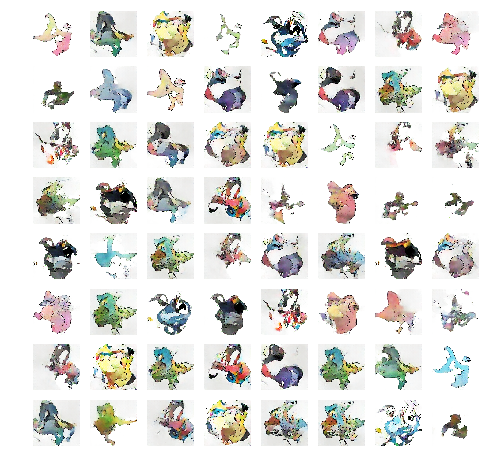

Time for epoch 248 is 70.88043642044067 sec
Epoch: 248, Dis. Loss: -58112208.0000, Gen. Loss: 26473994.0000


In [ ]:
wgan.train()